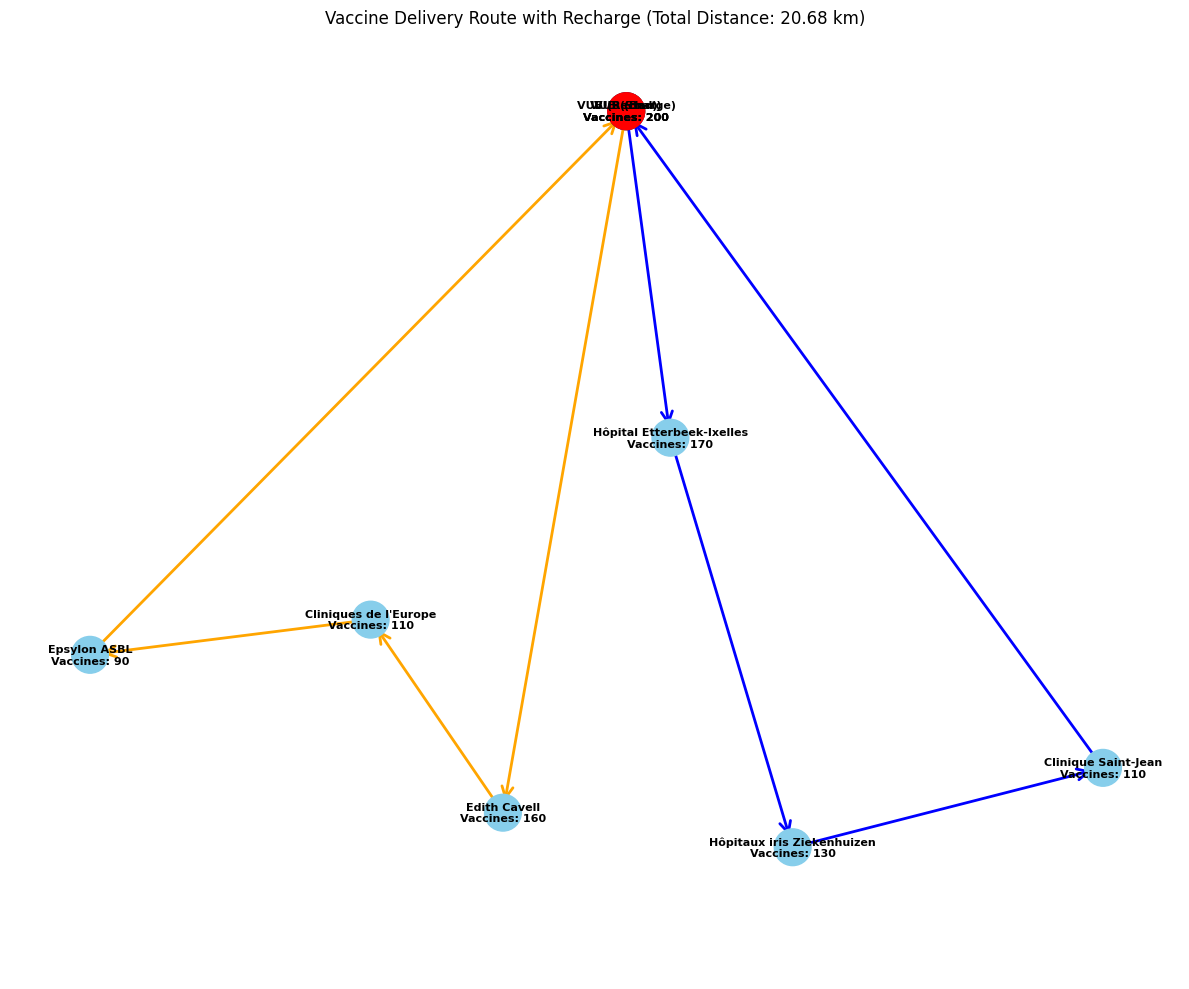

Total distance: 20.68 km
l1 =  ['VUB', 'Hôpital Etterbeek-Ixelles', 'Hôpitaux iris Ziekenhuizen', 'Clinique Saint-Jean', 'VUB']
l2 =  ['VUB', 'Edith Cavell', "Cliniques de l'Europe", 'Epsylon ASBL', 'VUB']
['VUB', 'Hôpital Etterbeek-Ixelles', 'Hôpitaux iris Ziekenhuizen', 'Clinique Saint-Jean', 'VUB', 'Edith Cavell', "Cliniques de l'Europe", 'Epsylon ASBL', 'VUB']


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import permutations, combinations
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r

def optimize_vaccine_delivery_with_recharge(vaccines_hospitals, real_coordinates, initial_vaccines=200):
    """
    Find the shortest path to deliver vaccines to all hospitals, starting and ending at VUB,
    with one recharge stop at VUB after visiting at least 2 other hospitals.
    
    Args:
        vaccines_hospitals: Dictionary mapping hospital names to vaccine amounts
        real_coordinates: Dictionary mapping hospital names to (lat, lon) coordinates
        initial_vaccines: Initial vaccine payload
    
    Returns:
        optimal_path: List of hospital names in optimal order
        total_distance: Total distance traveled in km
        vaccine_amounts: List of vaccine amounts at each step
    """
    # Create a list of all hospitals (excluding VUB which is start/end)
    hospitals = [h for h in vaccines_hospitals.keys() if h != "VUB"]
    
    # Create a distance matrix
    n = len(hospitals) + 1  # +1 for VUB
    all_locations = ["VUB"] + hospitals
    distance_matrix = np.zeros((n, n))
    
    for i, loc1 in enumerate(all_locations):
        for j, loc2 in enumerate(all_locations):
            if i != j:
                lat1, lon1 = real_coordinates[loc1]
                lat2, lon2 = real_coordinates[loc2]
                distance_matrix[i, j] = haversine_distance(lat1, lon1, lat2, lon2)
    
    # Try all possible splits of the hospitals into two groups
    min_distance = float('inf')
    optimal_path = None
    
    # We need at least 2 hospitals in the first group
    for split_point in range(2, len(hospitals) - 1):  # Leave at least 1 hospital for the second group
        for first_group in combinations(hospitals, split_point):
            remaining = [h for h in hospitals if h not in first_group]
            
            # Try all permutations of the first group
            for perm1 in permutations(first_group):
                # Try all permutations of the remaining hospitals
                for perm2 in permutations(remaining):
                    # Create full path: VUB -> perm1 -> VUB (recharge) -> perm2 -> VUB
                    path = ["VUB"] + list(perm1) + ["VUB"] + list(perm2) + ["VUB"]
                    
                    # Calculate total distance
                    total_dist = sum(distance_matrix[all_locations.index(path[i])][all_locations.index(path[i+1])] 
                                    for i in range(len(path)-1))
                    
                    if total_dist < min_distance:
                        min_distance = total_dist
                        optimal_path = path
    
    # Calculate vaccine amounts throughout the journey
    vaccine_amounts = [initial_vaccines]
    current_vaccines = initial_vaccines
    
    for hospital in optimal_path[1:]:
        if hospital == "VUB":
            # Recharge at VUB
            current_vaccines = initial_vaccines
        else:
            current_vaccines -= vaccines_hospitals[hospital]
        vaccine_amounts.append(current_vaccines)
    
    return optimal_path, min_distance, vaccine_amounts

def plot_vaccine_route_with_recharge(optimal_path, vaccine_amounts, real_coordinates):
    """
    Plot the optimal route on a map with vaccine amounts labeled.
    Highlight the recharge stop at VUB.
    
    Args:
        optimal_path: List of hospital names in optimal order
        vaccine_amounts: List of remaining vaccine amounts after each hospital
        real_coordinates: Dictionary mapping hospital names to (lat, lon) coordinates
    """
    plt.figure(figsize=(12, 10))
    
    # Create a directed graph but handle the nodes differently
    G = nx.DiGraph()
    
    # Find the recharge stop index
    recharge_index = optimal_path[1:].index("VUB") + 1
    
    # Create unique node IDs for each occurrence of a hospital
    unique_nodes = []
    for i, hospital in enumerate(optimal_path):
        node_id = f"{hospital}_{i}"
        unique_nodes.append(node_id)
        G.add_node(node_id, pos=real_coordinates[hospital], label=hospital)
    
    # Add edges between unique nodes
    for i in range(len(unique_nodes) - 1):
        G.add_edge(unique_nodes[i], unique_nodes[i+1])
    
    # Get positions (using the real coordinates)
    pos = {node: real_coordinates[G.nodes[node]['label']] for node in G.nodes()}
    
    # Prepare node colors
    node_colors = []
    for i, node_id in enumerate(unique_nodes):
        hospital = G.nodes[node_id]['label']
        if hospital == "VUB":
            if i == 0:
                node_colors.append('green')  # Start
            elif i == len(unique_nodes) - 1:
                node_colors.append('red')    # End
            else:
                node_colors.append('purple') # Recharge
        else:
            node_colors.append('skyblue')
    
    # Draw the graph with special colors
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    
    # Draw edges with different colors for before and after recharge
    edges_before = [(unique_nodes[i], unique_nodes[i+1]) for i in range(recharge_index)]
    edges_after = [(unique_nodes[i], unique_nodes[i+1]) for i in range(recharge_index, len(unique_nodes)-1)]
    
    nx.draw_networkx_edges(G, pos, edgelist=edges_before, width=2, edge_color='blue', 
                          arrowstyle='->', arrowsize=20)
    nx.draw_networkx_edges(G, pos, edgelist=edges_after, width=2, edge_color='orange', 
                          arrowstyle='->', arrowsize=20)
    
    # Add labels with vaccine amounts
    labels = {}
    for i, node_id in enumerate(unique_nodes):
        hospital = G.nodes[node_id]['label']
        if hospital == "VUB":
            if i == 0:
                labels[node_id] = f"{hospital} (Start)\nVaccines: {vaccine_amounts[i]}"
            elif i == len(unique_nodes) - 1:
                labels[node_id] = f"{hospital} (End)\nVaccines: {vaccine_amounts[i]}"
            else:
                labels[node_id] = f"{hospital} (Recharge)\nVaccines: {vaccine_amounts[i]}"
        else:
            labels[node_id] = f"{hospital}\nVaccines: {vaccine_amounts[i]}"
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight='bold')
    
    # Add title with total distance
    plt.title(f"Vaccine Delivery Route with Recharge (Total Distance: {min_distance:.2f} km)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
vaccines_hospitals = {
    "Hôpital Etterbeek-Ixelles": 30,
    "Clinique Saint-Jean": 20,
    "Cliniques de l'Europe": 50,
    "Edith Cavell": 40,
    "Hôpitaux iris Ziekenhuizen": 40,
    "Epsylon ASBL": 20,
    "VUB": 0,
}

real_coordinates = {
    "VUB": (50.8222329, 4.3969074),
    "Edith Cavell": (50.8139343, 4.3578839),
    "Cliniques de l'Europe": (50.8050334, 4.3686235),
    "Epsylon ASBL": (50.7861456, 4.3666663),
    "Hôpital Etterbeek-Ixelles": (50.8252055, 4.3787444),
    "Clinique Saint-Jean": (50.8543172, 4.3603786),
    "Hôpitaux iris Ziekenhuizen": (50.8334341, 4.3559617),
}

# Find the optimal path with recharge and plot it
optimal_path, min_distance, vaccine_amounts = optimize_vaccine_delivery_with_recharge(vaccines_hospitals, real_coordinates)
plot_vaccine_route_with_recharge(optimal_path, vaccine_amounts, real_coordinates)

print(f"Total distance: {min_distance:.2f} km")
vub_indices = [i for i, loc in enumerate(optimal_path) if loc == 'VUB']
list1 = optimal_path[vub_indices[0]:vub_indices[1] + 1]
list2 = optimal_path[vub_indices[1]:vub_indices[2] + 1]

print("l1 = ", list1)
print("l2 = ", list2)



print(optimal_path)
# Find the recharge stop index and show the split
recharge_index = optimal_path[1:].index("VUB") + 1
first_segment = optimal_path[:recharge_index+1]
second_segment = optimal_path[recharge_index:]
